In [1]:
# script to combine summary urban form stats for all cities
# last edit Oct 25 2023 Peter Berrill

# load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.wkt import loads,dumps
from shapely import speedups
from shapely.geometry import Point, LineString, Polygon
speedups.enable()
from pyproj import CRS
from pysal.lib import weights
import pickle
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from citymob import import_csv_w_wkt_to_gdf
import networkx as nx
import osmnx as ox
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.ticker as mticker

crs0=3035

cities=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']
ua_year=['2018','2018','2018','2018','2018','2018','2018','2018','2012','2018','2018','2018','2012','2018','2018','2012','2012','2018','2012']
ua_ver=['v013','v013','v013','v013','v013','v013','v013','v013','revised_v021','v013','v013','v013','revised_v021','v013','v013','revised_v021','revised_v021','v013','revised_v021']

metrics=['n','m','k_avg','intersection_density_km','clean_intersection_density_km','street_length_total','street_density_km','streets_per_node_avg','street_length_avg']
nw_type='drive'
bld_dens_city=[]
pop_dens_city=[]
pop_city=[]
area_city=[]
d2c=[]
d2sc=[]
urb_fab=[]
urb=[]
comm=[]
int_dens=[]
street_len=[]
bike_share=[]
transit_access=[]

In [36]:
def get_area_shares(city):

    print(city)
    country=countries[cities.index(city)]

    # read in file of city boundaries
    if country=='Germany':
        fp='../outputs/city_boundaries/' + city + '_basic.csv'
    else: 
        fp='../outputs/city_boundaries/' + city + '.csv'
    gdf_boundary = import_csv_w_wkt_to_gdf(fp,crs=crs0,geometry_col='geometry')

    # land use
    year=ua_year[cities.index(city)]
    ver=ua_ver[cities.index(city)]

    if city=='Potsdam':
        fp='../../MSCA_data/UrbanAtlas/Berlin/Data/Berlin_UA2018_v013.gpkg'

    else: 
        fp='../../MSCA_data/UrbanAtlas/' + city + '/Data/' + city + '_UA' + year + '_' + ver +'.gpkg'
    LU=gpd.read_file(fp)
    LU.to_crs(crs0,inplace=True)

    LU_gdf=gpd.overlay(gdf_boundary,LU,how='intersection')
    LU_gdf['area2']=LU_gdf.area

    if year =='2012': LU_gdf.rename(columns={'class_2012':'class_2018'},inplace=True)
    # create urban fabric (residential) and commercial and road land-uses
    LU_gdf['Class']='Other'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)','Discontinuous medium density urban fabric (S.L. : 30% - 50%)','Discontinuous low density urban fabric (S.L. : 10% - 30%)','Discontinuous very low density urban fabric (S.L. : < 10%)','Continuous urban fabric (S.L. : > 80%)']),'Class']='Urban_Fabric'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Industrial, commercial, public, military and private units','Construction sites','Airports','Port areas']),'Class']='Industrial_Commercial'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'Class']='Road'

    # make a non-road classification, to calculate by reverse the road area
    LU_gdf['RoadStatus']='NonRoad'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'RoadStatus']='Road'

    # make an aggregated LU classification, this time distinguishing 'urban' and 'non-urban' areas
    LU_gdf['UrbanStatus']='Non-Urban'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)',
    'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
    'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
    'Discontinuous very low density urban fabric (S.L. : < 10%)',
    'Continuous urban fabric (S.L. : > 80%)',
    'Industrial, commercial, public, military and private units',
    'Sports and leisure facilities',
    'Green urban areas',
    'Isolated structures',
    'Mineral extraction and dump sites', # should this be included?
    'Fast transit roads and associated land',
    'Railways and associated land ',
    'Airports',
    'Other roads and associated land',
    'Port areas',
    'Construction sites',
    ]),'UrbanStatus']='Urban'

    class_area=pd.DataFrame(LU_gdf.groupby('Class')['area2'].sum()/LU_gdf['area2'].sum()).reset_index()
    urb_fab.append(class_area.loc[class_area['Class']=='Urban_Fabric','area2'].values[0])
    comm.append(class_area.loc[class_area['Class']=='Industrial_Commercial','area2'].values[0])

    urb_area=pd.DataFrame(LU_gdf.groupby('UrbanStatus')['area2'].sum()/LU_gdf['area2'].sum()).reset_index() 
    urb.append(urb_area.loc[urb_area['UrbanStatus']=='Urban','area2'].values[0])


In [ ]:
c=pd.Series(cities)
c.apply(get_area_shares)

In [2]:
pdens_mix_all_DE=pd.DataFrame(columns = ['geocode','Population','City'])
for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam']:
    popdens_mix=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density.csv',dtype={'geocode':str})
    popdens_mix['Population']=popdens_mix['Pop_2018']
    popdens_mix=popdens_mix.loc[:,['geocode','Population']]
    popdens_mix['City']=city
    pdens_mix_all_DE=pd.concat([pdens_mix_all_DE,popdens_mix])
pdens_mix_all_DE.reset_index(drop=True,inplace=True)
pdens_mix_all_DE['Country']='Germany'
pdens_mix_all_DE

,geocode,Population,City,Country
0,01067,15666.0,Dresden,Germany
1,01069,30154.0,Dresden,Germany
2,01097,17060.0,Dresden,Germany
3,01099,31714.0,Dresden,Germany
4,01108,6119.0,Dresden,Germany
...,...,...,...,...
169,14473,13451.0,Potsdam,Germany
170,14476,16667.0,Potsdam,Germany
171,14478,26578.0,Potsdam,Germany
172,14480,28694.0,Potsdam,Germany


In [3]:
pdens_mix_all_FR=pd.DataFrame(columns = ['geocode','Population','City','Country'])
for city in ['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Toulouse']:
    popdens_mix=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density_mixres.csv',dtype={'geocode':str})
    popdens_mix=popdens_mix.loc[:,['geocode','Population']]
    popdens_mix['City']=city
    popdens_mix['Country']='France'
    pdens_mix_all_FR=pd.concat([pdens_mix_all_FR,popdens_mix])
pdens_mix_all_FR.reset_index(drop=True,inplace=True)
pdens_mix_all_FR

,geocode,Population,City,Country
0,101,10226.67737,Clermont,France
1,102,16336.893857,Clermont,France
2,103,25629.005422,Clermont,France
3,104,8984.275272,Clermont,France
4,105001,3015.902235,Clermont,France
...,...,...,...,...
909,055017,3758.383461,Toulouse,France
910,056001,1892.703835,Toulouse,France
911,056002,3982.885656,Toulouse,France
912,056003,1253.629968,Toulouse,France


In [4]:
d2_all=pd.DataFrame(columns = ['geocode','minDist_subcenter','Distance2Center','City','Country'])
for city in ['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Toulouse','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam']:
    country=countries[cities.index(city)]
    d2=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'geocode':str})
    d2=d2.loc[:,['geocode','minDist_subcenter','Distance2Center']]
    d2['City']=city
    d2['Country']=country
    d2_all=pd.concat([d2_all,d2])
d2_all.reset_index(drop=True,inplace=True)
d2_all

,geocode,minDist_subcenter,Distance2Center,City,Country
0,101,1.830664,0.235196,Clermont,France
1,102,1.907124,0.536975,Clermont,France
2,103,0.305305,1.772067,Clermont,France
3,104,1.458591,0.647796,Clermont,France
4,105001,1.288424,1.758292,Clermont,France
...,...,...,...,...,...
1107,14467,1.72844,0.971364,Potsdam,Germany
1108,14469,1.190694,2.242515,Potsdam,Germany
1109,14476,6.128019,7.801996,Potsdam,Germany
1110,14473,3.265259,1.655724,Potsdam,Germany


In [5]:
trans_all=pd.DataFrame(columns = ['geocode','score_spatiotemporal','City','Country'])
for city in ['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Toulouse','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam']:
    country=countries[cities.index(city)]
    fp='../outputs/transit_access/'+city+'.csv'
    if country=='France':
        fp='../outputs/transit_access/'+city+'_temp.csv'
    tr=pd.read_csv(fp,dtype={'geocode':str})
    tr['City']=city
    tr['Country']=country
    trans_all=pd.concat([trans_all,tr])
trans_all.reset_index(drop=True,inplace=True)
trans_all

,geocode,score_spatiotemporal,City,Country
0,101,3466.309628,Clermont,France
1,102,2340.515419,Clermont,France
2,103,1847.541557,Clermont,France
3,104,3930.602663,Clermont,France
4,105001,1947.208299,Clermont,France
...,...,...,...,...
1148,14473,461.33818,Potsdam,Germany
1149,14476,88.72712,Potsdam,Germany
1150,14478,653.317221,Potsdam,Germany
1151,14480,787.262411,Potsdam,Germany


In [7]:
comb_FR=pdens_mix_all_FR.merge(d2_all,on=['Country','City','geocode'])
comb_FR=comb_FR.merge(trans_all,on=['Country','City','geocode'],how='left')

In [8]:
d2c_FR_other=np.average(comb_FR['Distance2Center'], weights=comb_FR['Population'])
d2sc_FR_other=np.average(comb_FR['minDist_subcenter'], weights=comb_FR['Population'])
d2c_FR_other

6.001820287433744

In [9]:
d2sc_FR_other

2.8758929938235887

In [10]:
comb_FR=comb_FR.fillna(0.0)

In [11]:
trans_FR_other=np.average(comb_FR['score_spatiotemporal'], weights=comb_FR['Population'])
trans_FR_other

1462.083127034399

In [12]:
comb_DE=pdens_mix_all_DE.merge(d2_all,on=['Country','City','geocode'])
comb_DE=comb_DE.merge(trans_all,on=['Country','City','geocode'],how='left')
comb_DE

,geocode,Population,City,Country,minDist_subcenter,Distance2Center,score_spatiotemporal
0,01067,15666.0,Dresden,Germany,1.625958,1.101689,3892.397977
1,01069,30154.0,Dresden,Germany,2.54082,0.790464,5092.349443
2,01097,17060.0,Dresden,Germany,0.37598,2.368241,4678.508396
3,01099,31714.0,Dresden,Germany,2.104873,4.329216,402.040894
4,01108,6119.0,Dresden,Germany,3.493979,12.514477,194.815985
...,...,...,...,...,...,...,...
169,14473,13451.0,Potsdam,Germany,3.265259,1.655724,461.33818
170,14476,16667.0,Potsdam,Germany,6.128019,7.801996,88.72712
171,14478,26578.0,Potsdam,Germany,2.426146,4.891427,653.317221
172,14480,28694.0,Potsdam,Germany,0.522689,6.366003,787.262411


In [13]:
d2c_DE_other=np.average(comb_DE['Distance2Center'], weights=comb_DE['Population'])
d2sc_DE_other=np.average(comb_DE['minDist_subcenter'], weights=comb_DE['Population'])
d2c_DE_other

4.433429643903551

In [14]:
d2sc_DE_other

2.431991952045285

In [15]:
comb_DE=comb_DE.fillna(0.0)

In [16]:
trans_DE_other=np.average(comb_DE['score_spatiotemporal'], weights=comb_DE['Population'])
trans_DE_other

1653.396947257121

In [2]:
def get_UF_avg(city):
    print(city)
    country=countries[cities.index(city)]

    # bldg dens
    if city == 'Frankfurt am Main': 
        fp='../../MSCA_data/BuildingsDatabase/clips/eubucco_frankfurt_am_main.shp'
    else:
        fp='../../MSCA_data/BuildingsDatabase/clips/eubucco_' + city + '.shp'
    buildings_gdf=gpd.read_file(fp)

    # read in file of city boundaries
    if country=='Germany':
        fp='../outputs/city_boundaries/' + city + '_basic.csv'
    else: 
        fp='../outputs/city_boundaries/' + city + '.csv'
    gdf_boundary = import_csv_w_wkt_to_gdf(fp,crs=crs0,geometry_col='geometry')

    buildings_gdf=gpd.sjoin(buildings_gdf,gdf_boundary)

    # calculate the area of the buidlings from the database
    buildings_gdf["area"] = buildings_gdf["geometry"].area
    # calculate the centerpoint of each building geometry, 
    buildings_gdf["center"] = buildings_gdf["geometry"].centroid

    buildings_gdf['volume']=buildings_gdf['area']*buildings_gdf['height']
    bld_dens=buildings_gdf['volume'].sum()/gdf_boundary.area
    bld_dens_city.append(bld_dens.values[0])

    # pop dens
    dens=pd.read_excel('../outputs/density_geounits/summary_stats_' + city + '.xlsx',sheet_name='area_pop_sum')
    country=countries[cities.index(city)]
    # pop density city wide
    if country=='Germany':
        pop_dens=dens.loc[dens['variable']=='density','value'].reset_index(drop=True)[0]
        pop_total=dens.loc[dens['variable']=='Pop_2018','value'].reset_index(drop=True)[0]
        area=dens.loc[dens['variable']=='Area','value'].reset_index(drop=True)[0]
    else:
        pop_dens=dens.loc[dens['index']=='density',0].values[0]
        pop_total=dens.loc[dens['index']=='population',0].values[0]
        area=dens.loc[dens['index']=='area',0].values[0]   

    pop_dens_city.append(pop_dens)
    pop_city.append(pop_total)
    area_city.append(area)

    # pop density local, used for weighting distance and transit access metrics
    if country=='Germany':
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density.csv')
        pop_dens_local['Population']=pop_dens_local['Pop_2018']
    elif (country in ['France', 'Spain']) & (city != 'Paris'):
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density_mixres.csv')
        pop_dens_local['Population']=pop_dens_local['area']*pop_dens_local['Density']
    elif city =='Paris':
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density_lowres.csv')
        pop_dens_local.rename(columns={'geo_unit':'geocode'},inplace=True)
    else:
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density.csv')

    # distances, weighted avg by population
    data=pd.read_csv('../outputs/Combined/'+city+'_UF.csv')
    data=data.loc[:,['Res_geocode','HHNR','DistSubcenter_res', 'DistCenter_res']].drop_duplicates()

    data=pd.merge(data,pop_dens_local.loc[:,['geocode','Population']],left_on='Res_geocode',right_on='geocode')
    data=data.fillna(value=0.0) 
    dc=np.average(data['DistCenter_res'],weights=data['Population'])
    dsc=np.average(data['DistSubcenter_res'],weights=data['Population'])

    d2c.append(dc)
    d2sc.append(dsc)

    # transit access
    fp='../outputs/transit_access/'+city+'.csv'
    tr=pd.read_csv(fp)
    # trmean=tr['score_spatiotemporal'].mean()
    tr_weighted=pd.merge(tr,pop_dens_local.loc[:,['geocode','Population']])
    tr_weighted=tr_weighted.fillna(value=0.0) 
    trmean=np.average(tr_weighted['score_spatiotemporal'], weights=tr_weighted['Population'])
    transit_access.append(trmean)

    # land use
    year=ua_year[cities.index(city)]
    ver=ua_ver[cities.index(city)]

    if city=='Potsdam':
        fp='../../MSCA_data/UrbanAtlas/Berlin/Data/Berlin_UA2018_v013.gpkg'

    else: 
        fp='../../MSCA_data/UrbanAtlas/' + city + '/Data/' + city + '_UA' + year + '_' + ver +'.gpkg'
    LU=gpd.read_file(fp)
    LU.to_crs(crs0,inplace=True)

    LU_gdf=gpd.overlay(gdf_boundary,LU,how='intersection')

    if year =='2012': LU_gdf.rename(columns={'class_2012':'class_2018'},inplace=True)
    # create urban fabric (residential) and commercial and road land-uses
    LU_gdf['Class']='Other'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)','Discontinuous medium density urban fabric (S.L. : 30% - 50%)','Discontinuous low density urban fabric (S.L. : 10% - 30%)','Discontinuous very low density urban fabric (S.L. : < 10%)','Continuous urban fabric (S.L. : > 80%)']),'Class']='Urban_Fabric'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Industrial, commercial, public, military and private units','Construction sites','Airports','Port areas']),'Class']='Industrial_Commercial'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'Class']='Road'

    # make a non-road classification, to calculate by reverse the road area
    LU_gdf['RoadStatus']='NonRoad'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Fast transit roads and associated land','Other roads and associated land']),'RoadStatus']='Road'

    # make an aggregated LU classification, this time distinguishing 'urban' and 'non-urban' areas
    LU_gdf['UrbanStatus']='Non-Urban'
    LU_gdf.loc[LU_gdf['class_2018'].isin(['Discontinuous dense urban fabric (S.L. : 50% -  80%)',
    'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
    'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
    'Discontinuous very low density urban fabric (S.L. : < 10%)',
    'Continuous urban fabric (S.L. : > 80%)',
    'Industrial, commercial, public, military and private units',
    'Sports and leisure facilities',
    'Green urban areas',
    'Isolated structures',
    'Mineral extraction and dump sites', # should this be included?
    'Fast transit roads and associated land',
    'Railways and associated land ',
    'Airports',
    'Other roads and associated land',
    'Port areas',
    'Construction sites',
    ]),'UrbanStatus']='Urban'

    class_area=pd.DataFrame(LU_gdf.groupby('Class')['area'].sum()/LU_gdf['area'].sum()).reset_index()
    urb_fab.append(class_area.loc[class_area['Class']=='Urban_Fabric','area'].values[0])
    comm.append(class_area.loc[class_area['Class']=='Industrial_Commercial','area'].values[0])

    urb_area=pd.DataFrame(LU_gdf.groupby('UrbanStatus')['area'].sum()/LU_gdf['area'].sum()).reset_index()

    # connectivity

    poly = gdf_boundary.to_crs(4326).iloc[0].geometry

    graph_plz=ox.graph_from_polygon(poly,simplify=True,network_type=nw_type,retain_all=True)
    graph_proj=ox.project_graph(graph_plz)

    # get area
    graph_area=gdf_boundary.area.values[0]

    # get basic stats
    stats = ox.basic_stats(graph_proj,area=graph_area,clean_int_tol=10)

    # restrict to stats we are interested in
    stats1=dict((k, stats[k]) for k in metrics if k in stats)
    op=pd.Series(stats1)

    cf = '["cycleway"]'
    # this might throw an error if no graph is found within the polygon
    graph_bike = ox.graph_from_polygon(poly, custom_filter=cf,retain_all=True)
    if len(graph_bike.edges)>0:
        graph_proj2=ox.project_graph(graph_bike)
        stats = ox.basic_stats(graph_proj2,area=graph_area,clean_int_tol=10)
        stats2=dict((k, stats[k]) for k in metrics if k in stats)
        bike_lane_share=round(stats2['street_length_total']/stats1['street_length_total'],4)
    else:
        bike_lane_share=0
    #op=op.append(pd.Series({'bike_lane_share': bike_lane_share}))

    int_dens.append(op['clean_intersection_density_km'])
    street_len.append(op['street_length_avg'])
    bike_share.append(bike_lane_share)

In [3]:
def get_UF_avg_lite(city):
    print(city)
    country=countries[cities.index(city)]

    # pop dens
    dens=pd.read_excel('../outputs/density_geounits/summary_stats_' + city + '.xlsx',sheet_name='area_pop_sum')
    country=countries[cities.index(city)]
    # pop density city wide
    if country=='Germany':
        pop_dens=dens.loc[dens['variable']=='density','value'].reset_index(drop=True)[0]
        pop_total=dens.loc[dens['variable']=='Pop_2018','value'].reset_index(drop=True)[0]
        area=dens.loc[dens['variable']=='Area','value'].reset_index(drop=True)[0]
    else:
        pop_dens=dens.loc[dens['index']=='density',0].values[0]
        pop_total=dens.loc[dens['index']=='population',0].values[0]
        area=dens.loc[dens['index']=='area',0].values[0]   

    pop_dens_city.append(pop_dens)
    pop_city.append(pop_total)
    area_city.append(area)

    # pop density local, used for weighting distance and transit access metrics
    if country=='Germany':
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density.csv')
        pop_dens_local['Population']=pop_dens_local['Pop_2018']
    elif (country in ['France', 'Spain']) & (city != 'Paris'):
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density_mixres.csv')
        #pop_dens_local['Population']=pop_dens_local['area']*pop_dens_local['Density']
    elif city =='Paris':
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density_lowres.csv')
        pop_dens_local.rename(columns={'geo_unit':'geocode'},inplace=True)
    else:
        pop_dens_local=pd.read_csv('../outputs/density_geounits/' + city + '_pop_density.csv')

    # distances, weighted avg by population
    #data=pd.read_csv('../outputs/Combined/'+city+'_UF.csv')
    #data=data.loc[:,['Res_geocode','HHNR','DistSubcenter_res', 'DistCenter_res']].drop_duplicates()

    #data=pd.merge(data,pop_dens_local.loc[:,['geocode','Population']],left_on='Res_geocode',right_on='geocode')
    d2=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv')
    data=pd.merge(d2,pop_dens_local.loc[:,['geocode','Population']],left_on='geocode',right_on='geocode')
    data=data.fillna(value=0.0) 
    # dc=np.average(data['DistCenter_res'],weights=data['Population'])
    # dsc=np.average(data['DistSubcenter_res'],weights=data['Population'])
    dc=np.average(data['Distance2Center'],weights=data['Population'])
    dsc=np.average(data['minDist_subcenter'],weights=data['Population'])
		
    d2c.append(dc)
    d2sc.append(dsc)

    # transit access
    fp='../outputs/transit_access/'+city+'.csv'
    tr=pd.read_csv(fp)
    # trmean=tr['score_spatiotemporal'].mean()
    tr_weighted=pd.merge(tr,pop_dens_local.loc[:,['geocode','Population']])
    tr_weighted=tr_weighted.fillna(value=0.0) 
    trmean=np.average(tr_weighted['score_spatiotemporal_min'], weights=tr_weighted['Population'])
    transit_access.append(trmean)



In [4]:
c=pd.Series(cities)
c.apply(get_UF_avg_lite)

Berlin


KeyError: 'score_spatiotemporal'

In [ ]:
c=pd.Series(cities)
c.apply(get_UF_avg)

Berlin


C:\Users\peter\AppData\Local\Temp\ipykernel_7232\1993487070.py:61: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('../outputs/Combined/'+city+'_UF.csv')


Dresden
Düsseldorf
Frankfurt am Main
Kassel


C:\Users\peter\AppData\Local\Temp\ipykernel_7232\1993487070.py:61: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('../outputs/Combined/'+city+'_UF.csv')


Leipzig
Magdeburg
Potsdam
Clermont
Dijon
Lille
Lyon
Montpellier
Nantes
Nimes
Paris
Toulouse
Madrid


C:\Users\peter\AppData\Local\Temp\ipykernel_7232\1993487070.py:61: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('../outputs/Combined/'+city+'_UF.csv')


Wien


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
dtype: object

In [19]:
df_summ_lite=pd.DataFrame({'cities':c,'Population':pop_city,'Area':area_city,'Pop. density':pop_dens_city,'Dist. to center':d2c,'Dist. to subcenter':d2sc,'Transit accessibility':transit_access})
df_summ_lite['Pop']=df_summ_lite['Population']*1e-6
df_summ_lite

,cities,Population,Area,Pop. density,Dist. to center,Dist. to subcenter,Transit accessibility,Pop
0,Berlin,3.748148e+06,891.177023,4205.840032,8.426453,2.362838,2958.281595,3.748148
1,Dresden,5.654610e+05,328.261060,1722.595424,4.912877,3.023110,2406.562064,0.565461
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,4.461267,2.476586,2133.974869,0.642247
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,4.954017,2.074549,1439.983319,0.747318
4,Kassel,2.049270e+05,108.101396,1895.692446,2.896925,2.593059,931.920679,0.204927
5,Leipzig,5.957760e+05,297.885248,2000.018480,4.439803,2.613412,1414.379025,0.595776
6,Magdeburg,2.424780e+05,201.683212,1202.271608,3.326607,1.686011,1275.409414,0.242478
7,Potsdam,1.781850e+05,188.339722,946.082952,3.880201,2.117823,569.452662,0.178185
8,Clermont,2.844050e+05,311.166203,913.997076,4.091220,2.382071,1173.618374,0.284405
9,Dijon,2.521200e+05,241.068735,1045.842798,3.120561,2.606100,1355.590945,0.252120


In [20]:
df_summ_lite.to_csv('../outputs/summary_stats/summary_UF_all_reweighted.csv',index=False)

In [ ]:
df_summ=pd.DataFrame({'cities':c,'Population':pop_city,'Area':area_city,'Pop. density':pop_dens_city,'Built-up Density':bld_dens_city,'Dist. to center':d2c,'Dist. to subcenter':d2sc,
                      'Intersec. Density':int_dens,'Street length avg.':street_len,'Cycle lane share':bike_share,'Urban fabric area':urb_fab,'Comm. area':comm,'Transit accessibility':transit_access})
df_summ.loc[:,['Cycle lane share','Urban fabric area','Comm. area']]=df_summ.loc[:,['Cycle lane share','Urban fabric area','Comm. area']]*100
df_summ['Pop']=df_summ['Population']*1e-6
df_summ

,cities,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop
0,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148
1,Dresden,5.654610e+05,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318
4,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927
5,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776
6,Magdeburg,2.424780e+05,201.683212,1202.271608,0.627584,2.734132,1.798200,15.593762,144.723497,13.26,9.740381,8.351608,1275.409414,0.242478
7,Potsdam,1.782530e+05,188.339722,946.444002,0.259538,4.147738,2.007089,10.613799,147.280474,4.74,4.993357,2.677160,572.038101,0.178253
8,Clermont,2.844050e+05,311.166203,913.997076,0.449788,2.389599,1.815130,25.336974,97.337483,3.00,12.089983,7.702762,1173.618374,0.284405
9,Dijon,2.521200e+05,241.068735,1045.842798,0.404685,2.248755,2.536031,21.773911,105.650621,2.53,8.380765,7.753169,1355.590945,0.252120


In [ ]:
df_summ=pd.DataFrame({'cities':c,'Population':pop_city,'Area':area_city,'Pop. density':pop_dens_city,'Built-up Density':bld_dens_city,'Dist. to center':d2c,'Dist. to subcenter':d2sc,
                      'Intersec. Density':int_dens,'Street length avg.':street_len,'Cycle lane share':bike_share,'Urban fabric area':urb_fab,'Comm. area':comm,'Transit accessibility':transit_access})
df_summ.loc[:,['Cycle lane share','Urban fabric area','Comm. area']]=df_summ.loc[:,['Cycle lane share','Urban fabric area','Comm. area']]*100
df_summ['Pop']=df_summ['Population']*1e-6
df_summ

,cities,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop
0,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148
1,Dresden,5.654610e+05,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318
4,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927
5,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776
6,Magdeburg,2.424780e+05,201.683212,1202.271608,0.627584,2.734132,1.798200,15.593762,144.723497,13.26,9.740381,8.351608,1275.409414,0.242478
7,Potsdam,1.782530e+05,188.339722,946.444002,0.259538,4.147738,2.007089,10.613799,147.280474,4.74,4.993357,2.677160,572.038101,0.178253
8,Clermont,2.848300e+05,311.166203,915.362906,0.449788,2.491963,1.851700,25.336974,97.337483,3.00,12.089983,7.702762,1125.258219,0.284830
9,Dijon,2.522080e+05,241.068735,1046.207839,0.404685,2.285327,2.541356,21.773911,105.650621,2.53,8.380765,7.753169,1333.328757,0.252208


In [ ]:
fp='../outputs/summary_stats/summary_UF_all.csv'
df_summ.to_csv(fp,index=False)

In [ ]:
df_summ=pd.read_csv('../outputs/summary_stats/summary_UF_all.csv')
df_summ

,cities,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop
0,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148
1,Dresden,5.654610e+05,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318
4,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927
5,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776
6,Magdeburg,2.424780e+05,201.683212,1202.271608,0.627584,2.734132,1.798200,15.593762,144.723497,13.26,9.740381,8.351608,1275.409414,0.242478
7,Potsdam,1.782530e+05,188.339722,946.444002,0.259538,4.147738,2.007089,10.613799,147.280474,4.74,4.993357,2.677160,572.038101,0.178253
8,Clermont,2.844050e+05,311.166203,913.997076,0.449788,2.389599,1.815130,25.336974,97.337483,3.00,12.089983,7.702762,1173.618374,0.284405
9,Dijon,2.521200e+05,241.068735,1045.842798,0.404685,2.248755,2.536031,21.773911,105.650621,2.53,8.380765,7.753169,1355.590945,0.252120


In [ ]:
df_urb=pd.DataFrame({'cities':c,'Urban area':urb})
df_summ=df_summ.merge(df_urb)
df_summ['UrbPop Density']=df_summ['Pop. density']/df_summ['Urban area']
df_summ

,cities,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Urban area,UrbPop Density
0,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148,0.684440,6144.935484
1,Dresden,5.654610e+05,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461,0.438014,3932.743961
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247,0.588414,5070.840952
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318,0.592050,5023.143001
4,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927,0.581253,3261.388013
5,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776,0.549292,3641.082403
6,Magdeburg,2.424780e+05,201.683212,1202.271608,0.627584,2.734132,1.798200,15.593762,144.723497,13.26,9.740381,8.351608,1275.409414,0.242478,0.427579,2811.809478
7,Potsdam,1.782530e+05,188.339722,946.444002,0.259538,4.147738,2.007089,10.613799,147.280474,4.74,4.993357,2.677160,572.038101,0.178253,0.315195,3002.726661
8,Clermont,2.844050e+05,311.166203,913.997076,0.449788,2.389599,1.815130,25.336974,97.337483,3.00,12.089983,7.702762,1173.618374,0.284405,0.371457,2460.571707
9,Dijon,2.521200e+05,241.068735,1045.842798,0.404685,2.248755,2.536031,21.773911,105.650621,2.53,8.380765,7.753169,1355.590945,0.252120,0.371388,2816.040390


In [ ]:
# now get mobility summary stats
city='Berlin'
df=pd.read_csv('../outputs/summary_stats/Berlin_stats.csv')
df['City']=city
df_all=df.copy()

for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']:
    df=pd.read_csv('../outputs/summary_stats/' + city + '_stats.csv')
    df['City']=city
    df_all=pd.concat([df_all,df])
df_all['City']=df_all['City'].replace('Wien','Vienna')

In [ ]:
summ_UF= df_summ  
summ_UF.rename(columns={'cities':'City'},inplace=True)
summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6
summ_UF['City']=summ_UF['City'].replace('Wien','Vienna')
summ_UF.head()

,City,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Urban area,UrbPop Density,Pop.
0,Berlin,3748148.0,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148,0.684440,6144.935484,3.748148
1,Dresden,565461.0,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461,0.438014,3932.743961,0.565461
2,Düsseldorf,642247.0,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247,0.588414,5070.840952,0.642247
3,Frankfurt am Main,747318.0,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318,0.592050,5023.143001,0.747318
4,Kassel,204927.0,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927,0.581253,3261.388013,0.204927


In [ ]:
df_all=df_all.merge(summ_UF.loc[:,['City','Population','Dist. to center','Pop. density','UrbPop Density','Pop.']])
df_all.sort_values(by='Pop. density',ascending=False,inplace=True)
df_all['Mode_Share']=df_all['Mode_Share']*100
df_all.head()

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,UrbPop Density,Pop.
107,Car,4.693219,40.231334,0.612123,NaN,Paris,6902389.0,6.71893,8466.314821,9651.426145,6.902389
106,Bike,0.147856,1.267453,NaN,NaN,Paris,6902389.0,6.71893,8466.314821,9651.426145,6.902389
110,All,11.665582,NaN,NaN,3.267682,Paris,6902389.0,6.71893,8466.314821,9651.426145,6.902389
109,Transit,5.818354,49.876244,NaN,NaN,Paris,6902389.0,6.71893,8466.314821,9651.426145,6.902389
108,Foot,0.704565,6.039688,NaN,NaN,Paris,6902389.0,6.71893,8466.314821,9651.426145,6.902389


In [ ]:
df_car_travel=df_all.loc[df_all['Mode']=='Car',]
df_car_travel['Country']='Germany'
df_car_travel.loc[df_car_travel['City'].isin(['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse']),'Country']='France'
df_car_travel.loc[df_car_travel['City']=='Madrid','Country']='Spain'
df_car_travel.loc[df_car_travel['City']=='Vienna','Country']='Austria'
df_car_travel.reset_index(inplace=True,drop=True)
df_car_travel.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_23800\1066688196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_travel['Country']='Germany'


,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,UrbPop Density,Pop.,Country
0,Car,4.693219,40.231334,0.612123,NaN,Paris,6.902389e+06,6.718930,8466.314821,9651.426145,6.902389,France
1,Car,6.172215,40.828279,0.566624,NaN,Berlin,3.748148e+06,8.501587,4205.840032,6144.935484,3.748148,Germany
2,Car,7.178261,54.635062,0.714697,NaN,Madrid,5.278678e+06,8.291385,3901.726238,7961.744183,5.278678,Spain
3,Car,9.733532,59.990118,0.724438,NaN,Düsseldorf,6.422470e+05,4.599795,2983.751307,5070.840952,0.642247,Germany
4,Car,8.727136,56.918422,0.737039,NaN,Frankfurt am Main,7.473180e+05,5.217463,2973.951304,5023.143001,0.747318,Germany


In [ ]:
# now calculate expontial relationships and plot Fig 1a, 1b, car travel and car mode share vs density

0.453


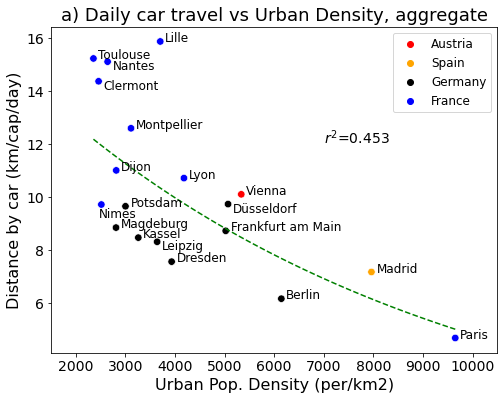

In [ ]:
# first with urban area population density
x=df_car_travel['UrbPop Density']
y=df_car_travel['Daily_Travel_cap']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='UrbPop Density', y='Daily_Travel_cap', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(1500, 10500)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    #plt.annotate(l, (df_car_travel['UrbPop Density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)
    if l=='Nimes':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-50, df_car_travel['Daily_Travel_cap'][i]-0.5), fontsize=12)
    elif l== ['Toulouse','Potsdam','Vienna','Magdeburg']:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-50, df_car_travel['Daily_Travel_cap'][i]+0.25), fontsize=12)
    elif l in ['Clermont','Leipzig','Nantes','Düsseldorf']:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.3), fontsize=12)        
    else:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)
plt.title('a) Daily car travel vs Urban Density, aggregate',fontsize=18)
plt.xlabel('Urban Pop. Density (per/km2)',fontsize=16)
plt.ylabel('Distance by car (km/cap/day)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,12),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Daily_car_travel_vs_UrbDensity_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

0.429


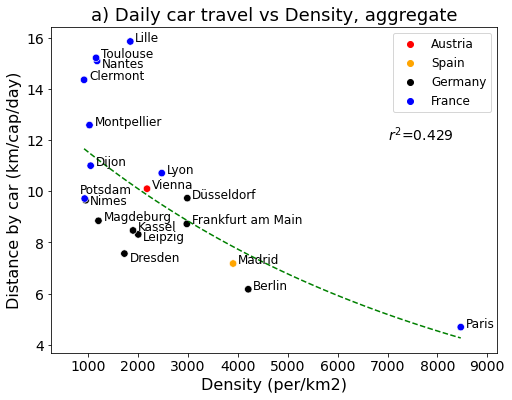

In [ ]:
x=df_car_travel['Pop. density']
y=df_car_travel['Daily_Travel_cap']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Pop. density', y='Daily_Travel_cap', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(250, 9200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    if l=='Dresden':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.3), fontsize=12)
    elif l== 'Potsdam':
        plt.annotate(l, (df_car_travel['Pop. density'][i]-120, df_car_travel['Daily_Travel_cap'][i]+0.25), fontsize=12)
    elif l in ['Leipzig','Nimes','Nantes']:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.25), fontsize=12)        
    else:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)

plt.title('a) Daily car travel vs Density, aggregate',fontsize=18)
plt.xlabel('Density (per/km2)',fontsize=16)
plt.ylabel('Distance by car (km/cap/day)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,12),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Daily_car_travel_vs_Density_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

0.61


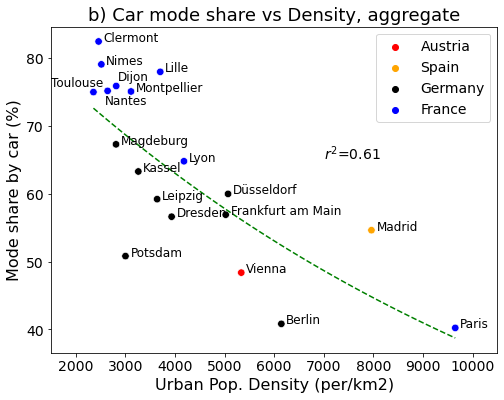

In [ ]:
# mode share vs urban pop density
x=df_car_travel['UrbPop Density']
y=df_car_travel['Mode_Share']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='UrbPop Density', y='Mode_Share', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(1500, 10500)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=14)
for i, l in enumerate (df_car_travel['City']):
    if l=='Nantes':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-50, df_car_travel['Mode_Share'][i]-2), fontsize=12)
    elif l== 'Toulouse':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-850, df_car_travel['Mode_Share'][i]+0.8), fontsize=12)
    elif l== 'Dijon':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+40, df_car_travel['Mode_Share'][i]+0.8), fontsize=12)            
    else:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+100, df_car_travel['Mode_Share'][i]), fontsize=12)

plt.title('b) Car mode share vs Density, aggregate',fontsize=18)
plt.xlabel('Urban Pop. Density (per/km2)',fontsize=16)
plt.ylabel('Mode share by car (%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,65),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Car_mode_share_vs_UrbDensity_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

0.533


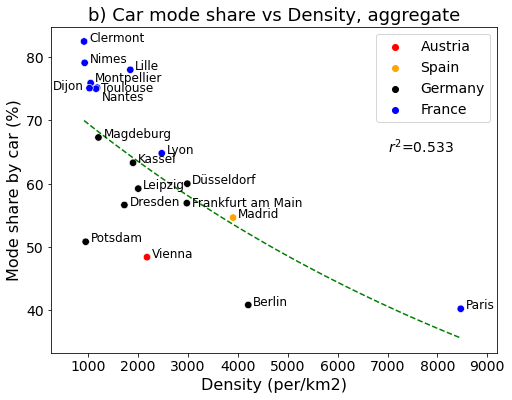

In [ ]:
x=df_car_travel['Pop. density']
y=df_car_travel['Mode_Share']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Pop. density', y='Mode_Share', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(250, 9200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=14)
for i, l in enumerate (df_car_travel['City']):
    if l=='Nantes':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]-2), fontsize=12)
    elif l== 'Dijon':
        plt.annotate(l, (df_car_travel['Pop. density'][i]-750, df_car_travel['Mode_Share'][i]-1), fontsize=12)
    elif l== 'Montpellier':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]+1), fontsize=12)       
    elif l in ['Frankfurt am Main','Toulouse']:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]-0.5), fontsize=12)       
    else:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]), fontsize=12)

plt.title('b) Car mode share vs Density, aggregate',fontsize=18)
plt.xlabel('Density (per/km2)',fontsize=16)
plt.ylabel('Mode share by car (%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,65),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Car_mode_share_vs_Density_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

In [ ]:
df_mode=df_all.loc[:,['City','Pop. density','Mode_Share','Mode']]
df_plot=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot=df_plot.merge(df_all.loc[:,['City','Pop. density']])
df_plot.sort_values(by='Pop. density',ascending=False,inplace=True)
df_plot.drop(columns='Pop. density',inplace=True)
df_plot.drop_duplicates(inplace=True)
df_plot.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot=df_plot.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]

df_comp=df_plot.merge(summ_UF.loc[:,['City','Population','Pop. density']])
df_comp[['Transit','Car','Foot','Population','Pop. density']].corr()

,Transit,Car,Foot,Population,Pop. density
Transit,1.000000,-0.922486,-0.305460,0.776981,0.756949
Car,-0.922486,1.000000,0.229075,-0.637635,-0.708259
Foot,-0.305460,0.229075,1.000000,-0.013512,0.054171
Population,0.776981,-0.637635,-0.013512,1.000000,0.904175
Pop. density,0.756949,-0.708259,0.054171,0.904175,1.000000


In [ ]:
# prepare some data for the bar chart of mode share
sns.set_palette(sns.color_palette('tab10'))

xt = np.array(range(0, 19))

size_sort_pop=summ_UF.sort_values(by='Pop.',ascending=False).reset_index(drop=True)

size_sort_dens=summ_UF.sort_values(by='Pop. density',ascending=False).reset_index(drop=True)


C:\Users\peter\AppData\Local\Temp\ipykernel_7232\1463150847.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_dens['City'].values)


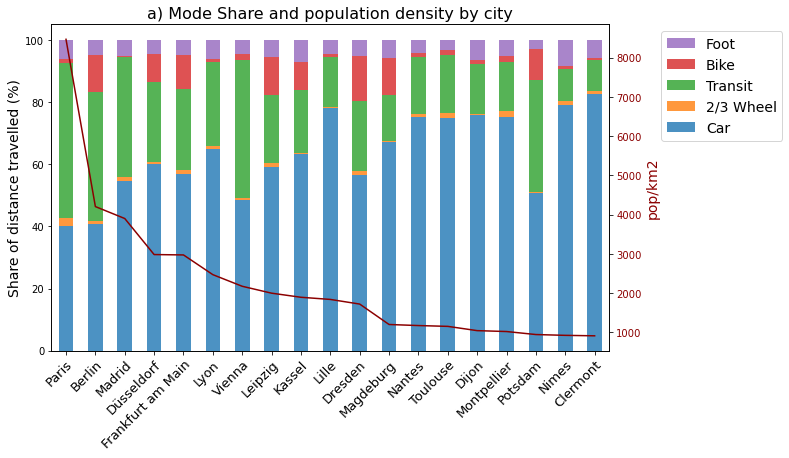

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
#plt.xlabel('Distance Bands (km)',fontsize=12)
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('a) Mode Share and population density by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_dens['City'],size_sort_dens['Pop. density'],color=c)
ax2.set_ylabel('pop/km2', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_dens['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)
#
plt.savefig('../figures/summary_all/mode_density_bar.png',facecolor='w',dpi=65,bbox_inches='tight')

In [ ]:
df_plot2=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot2=df_plot2.merge(df_all.loc[:,['City','Pop.']])
df_plot2.sort_values(by='Pop.',ascending=False,inplace=True)
df_plot2.drop(columns=['Pop.','All'],inplace=True)
df_plot2.drop_duplicates(inplace=True)
df_plot2.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot2=df_plot2.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]

C:\Users\peter\AppData\Local\Temp\ipykernel_7232\3581206263.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_pop['City'].values)


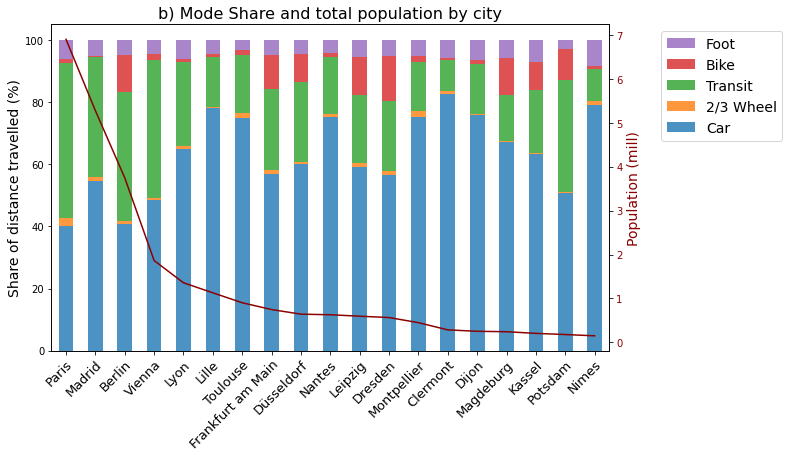

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot2.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot2['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('b) Mode Share and total population by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_pop['City'],size_sort_pop['Pop.'],color=c)
ax2.set_ylabel('Population (mill)', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_pop['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)
plt.savefig('../figures/summary_all/mode_pop_bar.png',facecolor='w',dpi=65,bbox_inches='tight')

In [ ]:
# now plot car mode share and ownership vs income for all cities with income data
inc_de=pd.read_csv('../figures/plots/income_stats_DE.csv')
inc_de['Country']='DE'

inc_fr=pd.read_csv('../figures/plots/income_stats_FR.csv')
inc_fr['Country']='FR'
inc_par=pd.read_csv('../figures/plots/income_stats_Paris.csv')
inc_par['Country']='FR'
inc_fr=pd.concat([inc_fr,inc_par])

inc=pd.concat([inc_de,inc_fr])
inc.reset_index(drop=True,inplace=True)
inc.loc[:,('CarOwnershipHH','Car_ModeShare')]=100*inc.loc[:,('CarOwnershipHH','Car_ModeShare')]
inc=inc.loc[inc['N_HH']>9,]
inc['City']=inc['City'].replace('Wien','Vienna')

inc['Region']=inc['City']
inc.loc[(inc['Country']=='DE') & (inc['City']!='Berlin'),'Region']='DE, other'
inc.loc[(inc['Country']=='FR') & (inc['City']!='Paris'),'Region']='FR, other'

inc['Region2']=inc['City']
inc.loc[inc['City'].isin(['Kassel','Magdeburg']),'Region2']='DE, small'
inc.loc[inc['City'].isin(['Frankfurt am Main','Dresden','Leipzig','Düsseldorf']),'Region2']='DE, mid'

inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable,Region,Region2
0,350.0,23.595506,14.947719,3.347351,22.393723,Berlin,89.0,DE,NaN,Berlin,Berlin
1,700.0,21.179625,15.623103,2.750800,17.607260,Berlin,373.0,DE,NaN,Berlin,Berlin
2,1200.0,38.309637,16.471699,5.235560,31.785186,Berlin,1266.0,DE,NaN,Berlin,Berlin
3,1750.0,53.955606,16.700901,6.626735,39.678905,Berlin,1757.0,DE,NaN,Berlin,Berlin
4,2300.0,66.178624,17.738077,7.960941,44.880521,Berlin,2049.0,DE,NaN,Berlin,Berlin
...,...,...,...,...,...,...,...,...,...,...,...
98,2700.0,68.951194,14.417273,6.652229,46.140693,Paris,963.0,FR,NaN,Paris,Paris
99,3250.0,78.278689,15.062989,6.704398,44.509083,Paris,732.0,FR,NaN,Paris,Paris
100,4000.0,83.118406,15.614525,7.391276,47.335900,Paris,853.0,FR,NaN,Paris,Paris
101,5000.0,85.361217,15.267702,6.948787,45.512988,Paris,526.0,FR,NaN,Paris,Paris


In [ ]:
cp=['tab:blue','tab:orange','tab:green','tab:brown','tab:purple','tab:gray','tab:red']

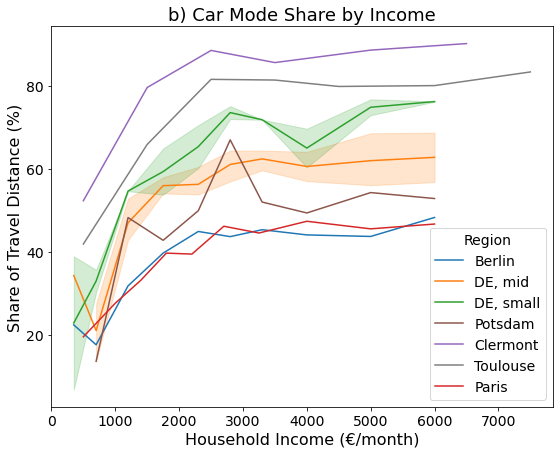

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc, hue='Region2',alpha=1,palette=cp)
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('b) Car Mode Share by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../figures/plots/All_CarModeShare_new.png',facecolor='w',dpi=65,bbox_inches='tight')

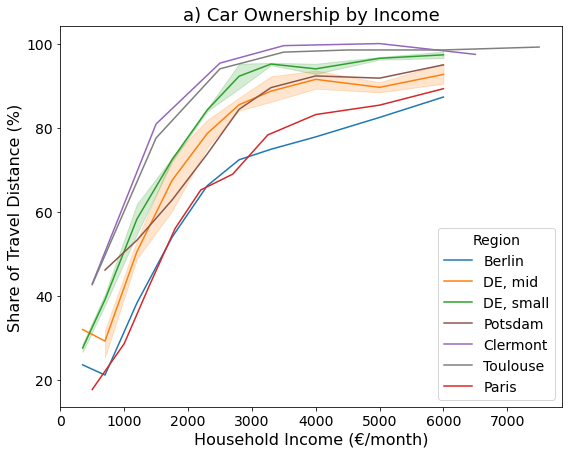

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='CarOwnershipHH', data=inc, hue='Region2',alpha=1,palette=cp)
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('a) Car Ownership by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../figures/plots/All_CarOwnership_new.png',facecolor='w',dpi=65,bbox_inches='tight')

In [ ]:
# now plot summary metrics vs dens/d2c with disagg data

# read in shapefile of user-defined (for now) city centers
centers=import_csv_w_wkt_to_gdf('../source/citycenters/centers.csv',crs=4326)
centers.to_crs(crs0,inplace=True)

In [ ]:
# function to plot figures mapping key metrics by postcode (or similar) for all cities
def get_data(city):
    print(city)
    country=countries[cities.index(city)]

    if country == 'Germany':
        # original source for postcode shapes for DE is https://www.suche-postleitzahl.org/downloads, the 5stelling.shp, downloaded Jun 8 2022
        fp='../../sufficcs_mobility/source/GTFS/postcodes_gpkg_all/'+city+'_postcodes'+'.gpkg'
        city_map=gpd.read_file(fp)
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country
        city_map['geocode']=city_map['geocode'].astype(str).str.zfill(5)
        dens=pd.read_csv('../outputs/density_geounits/'+city+'_pop_density.csv',dtype={'geocode':str})
        lu=pd.read_csv('../outputs/LU/UA_' + city + '.csv',dtype={'geocode':str})
        city_map=city_map.merge(dens.loc[:,['geocode','Density']])
        city_map=city_map.merge(lu.loc[:,['geocode','pc_urban']])
        
        if city == 'Berlin': # for Berlin, first in the loop, initiate the city_map_all df, and set the scaling factor based on Berlin. This will allow plots to be on comparabale scales later.
            global city_map_all
            city_map_all=city_map.copy()
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]
            global scale 
            scale=xex/14

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')
            city_stats.dropna(subset='Res_geocode',inplace=True)

            d2c=pd.read_csv('../outputs/CenterSubcenter/Berlin_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)

            city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')

            global city_stats_all
            city_stats_all=city_stats.copy()

        else:
            city_map_all=pd.concat([city_map_all,city_map])
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')

            d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)
            city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')
            city_stats_all=pd.concat([city_stats_all,city_stats])

    if country in ['France', 'Spain','Austria']:
        
        if city =='Wien': city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density.csv',crs=crs0,gc='geocode') #; city_map.rename(columns={'geocode':'geo_unit'},inplace=True)
        elif city == 'Paris': city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_lowres.csv',crs=crs0,gc='geo_unit'); city_map.rename(columns={'geo_unit':'geocode'},inplace=True)
        else: city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_lowres.csv',crs=crs0,gc='geocode'); city_map.rename(columns={'geo_unit':'geocode'},inplace=True)

        city_map['geocode']=city_map.loc[:,'geocode'].astype(str)
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country
        if city in ['Wien','Paris']:
            lu=pd.read_csv('../outputs/LU/UA_' + city + '.csv',dtype={'geocode':str})
        else:
            lu=pd.read_csv('../outputs/LU/UA_' + city + '_lowres.csv',dtype={'geocode':str})
        city_map=city_map.merge(lu.loc[:,['geocode','pc_urban']])

        city_map_all=pd.concat([city_map_all,city_map])
        xex=city_map.total_bounds[2]-city_map.total_bounds[0]
        yex=city_map.total_bounds[3]-city_map.total_bounds[1]

        if city in ['Paris','Wien']:  stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv')#; stats.rename(columns={'Res_geocode':'geocode'},inplace=True) #2nd part Paris only
        else: 
            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'_agg.csv')
            stats.rename(columns={'Res_geo_unit':'Res_geocode'},inplace=True)
            #stats.rename(columns={'geocode':'geo_unit'},inplace=True)
        stats['Res_geocode']=stats['Res_geocode'].astype(str)

        stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
        stats.fillna(0,inplace=True)
        city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')
        city_stats.dropna(subset='Res_geocode',inplace=True)

        if city in ['Paris','Wien']: d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
        else: d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist_lowres.csv') # here 
        d2c['geocode']=d2c['geocode'].astype(str)
        city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')
        city_stats_all=pd.concat([city_stats_all,city_stats])

    print('Finished gathering stats for ' + city)


In [ ]:
cities_all=pd.Series(cities)
cities_all.apply(get_data)

Berlin
Finished gathering stats for Berlin
Dresden
Finished gathering stats for Dresden
Düsseldorf
Finished gathering stats for Düsseldorf
Frankfurt am Main
Finished gathering stats for Frankfurt am Main
Kassel
Finished gathering stats for Kassel
Leipzig
Finished gathering stats for Leipzig
Magdeburg
Finished gathering stats for Magdeburg
Potsdam
Finished gathering stats for Potsdam
Clermont
Finished gathering stats for Clermont
Dijon
Finished gathering stats for Dijon
Lille
Finished gathering stats for Lille
Lyon
Finished gathering stats for Lyon
Montpellier
Finished gathering stats for Montpellier
Nantes
Finished gathering stats for Nantes
Nimes
Finished gathering stats for Nimes
Paris
Finished gathering stats for Paris
Toulouse
Finished gathering stats for Toulouse
Madrid
Finished gathering stats for Madrid
Wien
Finished gathering stats for Wien


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
dtype: object

In [ ]:
city_map_all.city.value_counts()

Berlin               190
Paris                150
Madrid               100
Lyon                  96
Lille                 57
Toulouse              56
Nantes                53
Montpellier           48
Wien                  44
Frankfurt am Main     41
Düsseldorf            37
Leipzig               34
Dresden               29
Dijon                 24
Nimes                 20
Clermont              19
Magdeburg             14
Kassel                11
Potsdam                8
Name: city, dtype: int64

In [ ]:
city_stats_all['Urb_Density']=city_stats_all['Density']/city_stats_all['pc_urban']
city_stats_all

,geocode,geometry,city,Country,Density,pc_urban,Res_geocode,Share_Distance_2_3_Wheel,Share_Distance_Bike,Share_Distance_Car,...,minDist_subcenter,Distance2Center,wgt_center,build_vol_density,area,Population,Municipality,Gemeindebezirk,state,Urb_Density
0,10115,"POLYGON ((4549301.927 3274885.716, 4549347.966...",Berlin,Germany,11370.000000,0.972475,10115,0.295374,18.236609,32.129916,...,2.761334,1.972959,POINT (4550629.490674428 3274468.7054230142),8.762172e+06,NaN,NaN,NaN,NaN,NaN,11691.822806
1,10117,"POLYGON ((4549705.754 3273759.814, 4549704.056...",Berlin,Germany,4718.000000,0.930039,10117,0.000000,9.565665,34.180259,...,3.479541,0.475295,POINT (4550878.28776072 3272787.7565771975),1.500578e+07,NaN,NaN,NaN,NaN,NaN,5072.905660
2,10119,"POLYGON ((4551420.499 3274832.680, 4551438.752...",Berlin,Germany,20298.000000,1.000000,10119,3.339934,35.230391,17.067975,...,2.130129,2.441003,POINT (4551993.17202827 3274431.0446406724),1.041094e+07,NaN,NaN,NaN,NaN,NaN,20298.000000
3,10178,"POLYGON ((4551337.970 3273487.103, 4551381.737...",Berlin,Germany,7834.000000,0.949514,10178,0.000000,8.008454,36.919196,...,3.082076,2.001693,POINT (4552274.531149771 3273426.1818071394),9.892036e+06,NaN,NaN,NaN,NaN,NaN,8250.535071
4,10179,"POLYGON ((4551854.044 3272298.103, 4551885.012...",Berlin,Germany,11352.000000,0.925761,10179,0.000000,9.545402,40.150239,...,2.157931,2.290879,POINT (4552790.564128403 3272537.9806010365),8.909345e+06,NaN,NaN,NaN,NaN,NaN,12262.339227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,91901,"POLYGON ((4791099.542 2816852.378, 4791118.632...",Wien,Austria,2729.274280,0.501761,91901,2.263847,0.868965,59.436668,...,2.419912,5.024988,POINT (4792024.001538325 2812872.6351867425),3.167028e+06,24.943994,68079.0,NaN,"Wien 19.,DÃ¶bling",Wien,5439.395874
40,92001,"POLYGON ((4793653.354 2813752.829, 4793648.668...",Wien,Austria,14531.507566,0.756335,92001,0.000000,1.590364,38.709297,...,2.351046,3.483303,POINT (4794327.535022468 2811979.030348179),1.713993e+07,5.709593,82969.0,NaN,"Wien 20.,Brigittenau",Wien,19213.060245
41,92101,"POLYGON ((4794324.743 2819184.701, 4794321.263...",Wien,Austria,3199.641659,0.636929,92101,0.287772,1.510442,48.060793,...,1.731069,7.753924,POINT (4796274.49510437 2816048.145838636),4.708174e+06,44.442164,142199.0,NaN,"Wien 21.,Floridsdorf",Wien,5023.546940
42,92201,"POLYGON ((4801674.734 2817519.699, 4801673.144...",Wien,Austria,1548.462806,0.442728,92201,3.341628,2.376874,55.375653,...,1.960275,6.944171,POINT (4800417.302578825 2812134.149572877),5.629804e+06,102.305977,158417.0,NaN,"Wien 22.,Donaustadt",Wien,3497.550321


In [ ]:
city_map_all['Urb_Density']=city_map_all['Density']/city_map_all['pc_urban']
city_map_all

,geocode,geometry,city,Country,Density,pc_urban,area,Population,Municipality,Gemeindebezirk,state,Urb Density,Urb_Density
0,10115,"POLYGON ((4549301.927 3274885.716, 4549347.966...",Berlin,Germany,11370.000000,0.972475,NaN,NaN,NaN,NaN,NaN,11691.822806,11691.822806
1,10117,"POLYGON ((4549705.754 3273759.814, 4549704.056...",Berlin,Germany,4718.000000,0.930039,NaN,NaN,NaN,NaN,NaN,5072.905660,5072.905660
2,10119,"POLYGON ((4551420.499 3274832.680, 4551438.752...",Berlin,Germany,20298.000000,1.000000,NaN,NaN,NaN,NaN,NaN,20298.000000,20298.000000
3,10178,"POLYGON ((4551337.970 3273487.103, 4551381.737...",Berlin,Germany,7834.000000,0.949514,NaN,NaN,NaN,NaN,NaN,8250.535071,8250.535071
4,10179,"POLYGON ((4551854.044 3272298.103, 4551885.012...",Berlin,Germany,11352.000000,0.925761,NaN,NaN,NaN,NaN,NaN,12262.339227,12262.339227
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,91901,"POLYGON ((4791099.542 2816852.378, 4791118.632...",Wien,Austria,2729.274280,0.501761,24.943994,68079.0,NaN,"Wien 19.,DÃ¶bling",Wien,5439.395874,5439.395874
40,92001,"POLYGON ((4793653.354 2813752.829, 4793648.668...",Wien,Austria,14531.507566,0.756335,5.709593,82969.0,NaN,"Wien 20.,Brigittenau",Wien,19213.060245,19213.060245
41,92101,"POLYGON ((4794324.743 2819184.701, 4794321.263...",Wien,Austria,3199.641659,0.636929,44.442164,142199.0,NaN,"Wien 21.,Floridsdorf",Wien,5023.546940,5023.546940
42,92201,"POLYGON ((4801674.734 2817519.699, 4801673.144...",Wien,Austria,1548.462806,0.442728,102.305977,158417.0,NaN,"Wien 22.,Donaustadt",Wien,3497.550321,3497.550321


In [ ]:
# now make summary figures and models of key variables from all cities
city_stats_df=pd.DataFrame(city_stats_all.drop(columns='geometry'))
df=city_stats_df.dropna(subset=('Daily_Distance_Person_Car','Density','Urb_Density','Distance2Center','Share_Distance_Car')).copy()
df=df.loc[:,('Country','city' ,'Daily_Distance_Person_Car','Density','Urb_Density','Distance2Center','Share_Distance_Car')]
df=df.loc[df['Daily_Distance_Person_Car']>0,:]
df.reset_index(drop=True,inplace=True)
# this is an alternative if we don't omit rows with non-zero car travel
# df.loc[:,'Daily_Distance_Person_Car']=df.loc[:,'Daily_Distance_Person_Car'].replace(0,0.5)
# df.loc[:,'Share_Distance_Car']=df.loc[:,'Share_Distance_Car'].replace(0,0.5)

df['Region']=df['city'].copy()
df.loc[(df['Country']=='France') & (df['city']!='Paris'),'Region']='FR_Other'
df.loc[(df['Country']=='Germany') & (df['city']!='Berlin'),'Region']='DE_Other'
regions=df['Region'].unique()

labs={'Daily_Distance_Person_Car':'Distance by Car (km/cap/day)','Density':'Density (per/km2)','Urb_Density':'Urban Pop. Density (per/km2)', 'Distance2Center':'Distance to Center (km)','Share_Distance_Car':'Mode Share by Car (%)'}

In [ ]:
# plot function
def plot_all(variables,rel,title):
    y=variables.split('*')[0]
    x=variables.split('*')[1]
    n=100
    x_fitted = np.linspace(np.min(df[x]), np.max(df[x]), n)
    xy=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta'])

    for r in regions:
        
        if r == 'All':
            x_r=df[x]
            y_r=df[y]
        else:
            x_r=df.loc[df['Region']==r,x]
            y_r=df.loc[df['Region']==r,y]

        if rel=='lin':
            z_r = np.polyfit(x_r, y_r, 1)
            p_r = np.poly1d(z_r)
            y_r_fit=p_r(x_fitted)
            r2_r=r2_score(y_r, p_r(x_r))
            Slope=z_r[0]
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

            xy=pd.concat([xy,xy_r])

        if rel=='exp':
            # exp fit
            a_r=np.exp(np.polyfit(x_r, np.log(y_r), 1)[1])
            b_r=np.polyfit(x_r, np.log(y_r), 1)[0]
            y_r_fit=a_r * np.exp(b_r * x_fitted)

            r2_r=r2_score(y_r, a_r * np.exp(b_r * x_r))
            Slope=b_r
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

            xy=pd.concat([xy,xy_r])
    xy.reset_index(drop=True,inplace=True)
    xy['Region_R2']=xy['Region'] + ' (' + xy['R2'].map(lambda x: round(x,2)).astype(str) + ')'

    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(ax=ax,x=x, y=y, data=df, hue='Region',alpha=0.5,s=30,legend=False)
    sns.lineplot(x='x_fit', y='y_fit', data=xy, hue='Region_R2',alpha=1)
    if y=='Daily_Distance_Person_Car':
        ax.set_ylim(0, 40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.title(title,fontsize=18)
    plt.xlabel(labs[x],fontsize=16)
    plt.ylabel(labs[y],fontsize=16)#
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
    #plt.show()
    plt.savefig('../figures/summary_all/' + title + '_' + rel + '_new.png',facecolor='w',dpi=300,bbox_inches='tight')

    print('R2:')
    print(round(xy.groupby('Region')['R2'].mean(),3))
    print('Slopes:')
    print(round(xy.groupby('Region')['Slope/Beta'].mean(),6))

    ret = pd.DataFrame(xy.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy.groupby('Region')['Slope/Beta'].mean()).reset_index())
    ret['Relationship']=title
    ret['Model']=rel

    return ret

In [ ]:
sns.set_palette(sns.color_palette('tab10'))
df['city']=df['city'].replace({'Wien':'Vienna'})
df['Region']=df['Region'].replace({'Wien':'Vienna'})
regions=df['Region'].unique()

R2:
Region
Berlin      0.454
DE_Other    0.083
FR_Other    0.535
Madrid      0.503
Paris       0.328
Vienna      0.302
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000065
DE_Other   -0.000040
FR_Other   -0.000069
Madrid     -0.000034
Paris      -0.000042
Vienna     -0.000065
Name: Slope/Beta, dtype: float64
R2:
Region
Berlin      0.463
DE_Other    0.140
FR_Other    0.619
Madrid      0.591
Paris       0.391
Vienna      0.249
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000044
DE_Other   -0.000028
FR_Other   -0.000033
Madrid     -0.000017
Paris      -0.000029
Vienna     -0.000028
Name: Slope/Beta, dtype: float64


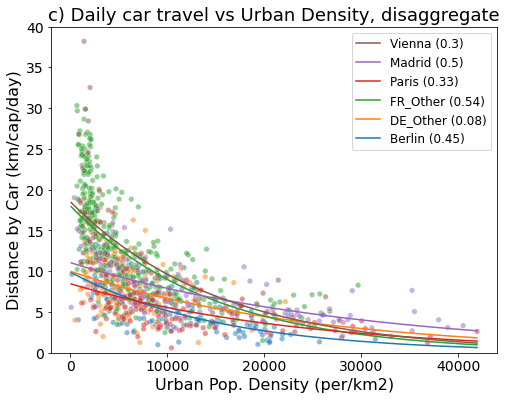

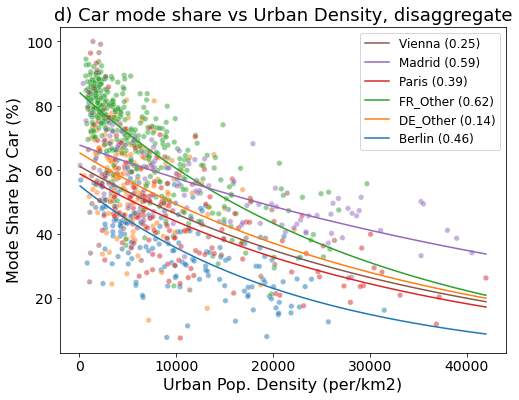

In [ ]:
car_dist_vs_density_exp=plot_all('Daily_Distance_Person_Car*Urb_Density','exp','c) Daily car travel vs Urban Density, disaggregate')
car_share_vs_density_exp=plot_all('Share_Distance_Car*Urb_Density','exp','d) Car mode share vs Urban Density, disaggregate')

In [ ]:
car_dist_vs_density_exp

,Region,R2,Slope/Beta,Relationship,Model
0,Berlin,0.454386,-0.000065,"c) Daily car travel vs Urban Density, disaggre...",exp
1,DE_Other,0.082578,-0.000040,"c) Daily car travel vs Urban Density, disaggre...",exp
2,FR_Other,0.535405,-0.000069,"c) Daily car travel vs Urban Density, disaggre...",exp
3,Madrid,0.502736,-0.000034,"c) Daily car travel vs Urban Density, disaggre...",exp
4,Paris,0.328442,-0.000042,"c) Daily car travel vs Urban Density, disaggre...",exp
5,Vienna,0.302344,-0.000065,"c) Daily car travel vs Urban Density, disaggre...",exp


In [ ]:
car_share_vs_density_exp

,Region,R2,Slope/Beta,Relationship,Model
0,Berlin,0.462636,-0.000044,"d) Car mode share vs Urban Density, disaggregate",exp
1,DE_Other,0.140273,-0.000028,"d) Car mode share vs Urban Density, disaggregate",exp
2,FR_Other,0.618510,-0.000033,"d) Car mode share vs Urban Density, disaggregate",exp
3,Madrid,0.590989,-0.000017,"d) Car mode share vs Urban Density, disaggregate",exp
4,Paris,0.390708,-0.000029,"d) Car mode share vs Urban Density, disaggregate",exp
5,Vienna,0.249302,-0.000028,"d) Car mode share vs Urban Density, disaggregate",exp


R2:
Region
Berlin      0.471
DE_Other    0.134
FR_Other    0.564
Madrid      0.514
Paris       0.338
Vienna      0.260
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000065
DE_Other   -0.000044
FR_Other   -0.000070
Madrid     -0.000032
Paris      -0.000043
Vienna     -0.000062
Name: Slope/Beta, dtype: float64
R2:
Region
Berlin      0.459
DE_Other    0.159
FR_Other    0.612
Madrid      0.560
Paris       0.382
Vienna      0.229
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000043
DE_Other   -0.000028
FR_Other   -0.000033
Madrid     -0.000015
Paris      -0.000029
Vienna     -0.000027
Name: Slope/Beta, dtype: float64


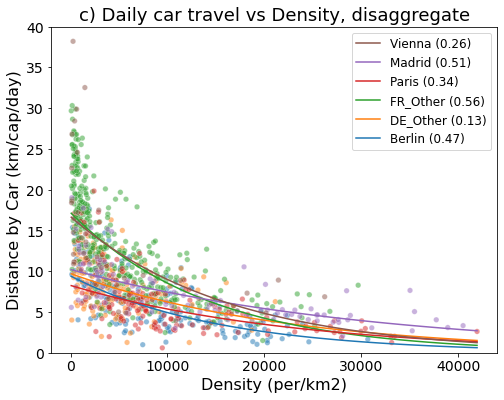

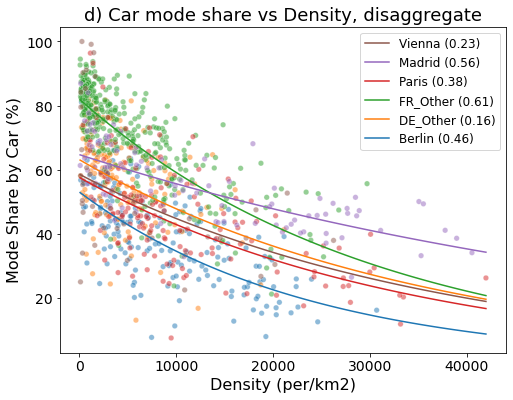

In [ ]:
car_dist_vs_density_exp=plot_all('Daily_Distance_Person_Car*Density','exp','c) Daily car travel vs Density, disaggregate')
car_share_vs_density_exp=plot_all('Share_Distance_Car*Density','exp','d) Car mode share vs Density, disaggregate')

R2:
Region
Berlin      0.666
DE_Other    0.221
FR_Other    0.521
Madrid      0.464
Paris       0.542
Vienna      0.390
Name: R2, dtype: float64
Slopes:
Region
Berlin      0.617135
DE_Other    0.594597
FR_Other    1.086896
Madrid      0.369097
Paris       0.522431
Vienna      1.456314
Name: Slope/Beta, dtype: float64
R2:
Region
Berlin      0.431
DE_Other    0.145
FR_Other    0.260
Madrid      0.351
Paris       0.433
Vienna      0.292
Name: R2, dtype: float64
Slopes:
Region
Berlin      2.058883
DE_Other    1.896498
FR_Other    1.814493
Madrid      1.084745
Paris       2.095266
Vienna      2.420081
Name: Slope/Beta, dtype: float64


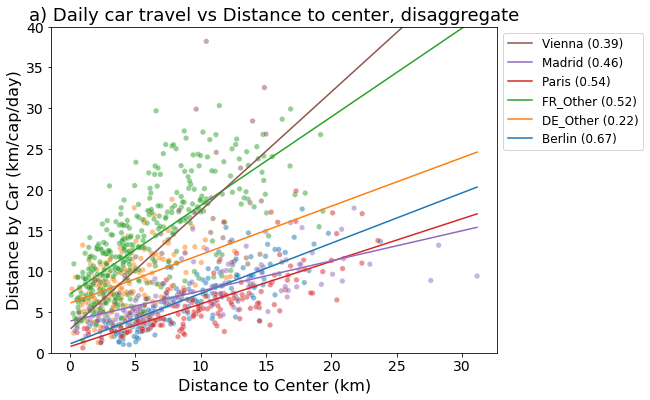

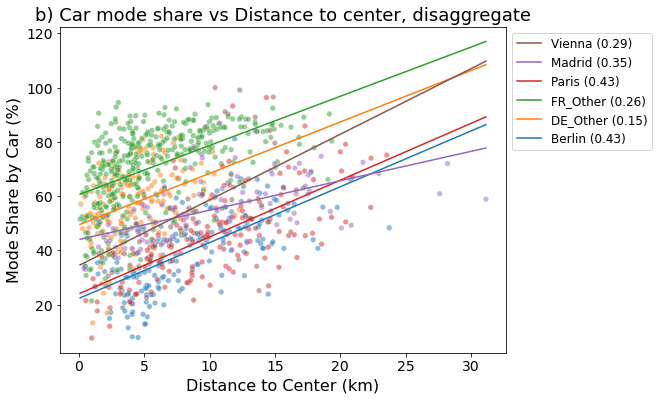

In [ ]:
car_dist_vs_d2c_lin=plot_all('Daily_Distance_Person_Car*Distance2Center','lin','a) Daily car travel vs Distance to center, disaggregate')
car_share_vs_d2c_lin=plot_all('Share_Distance_Car*Distance2Center','lin','b) Car mode share vs Distance to center, disaggregate')